25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


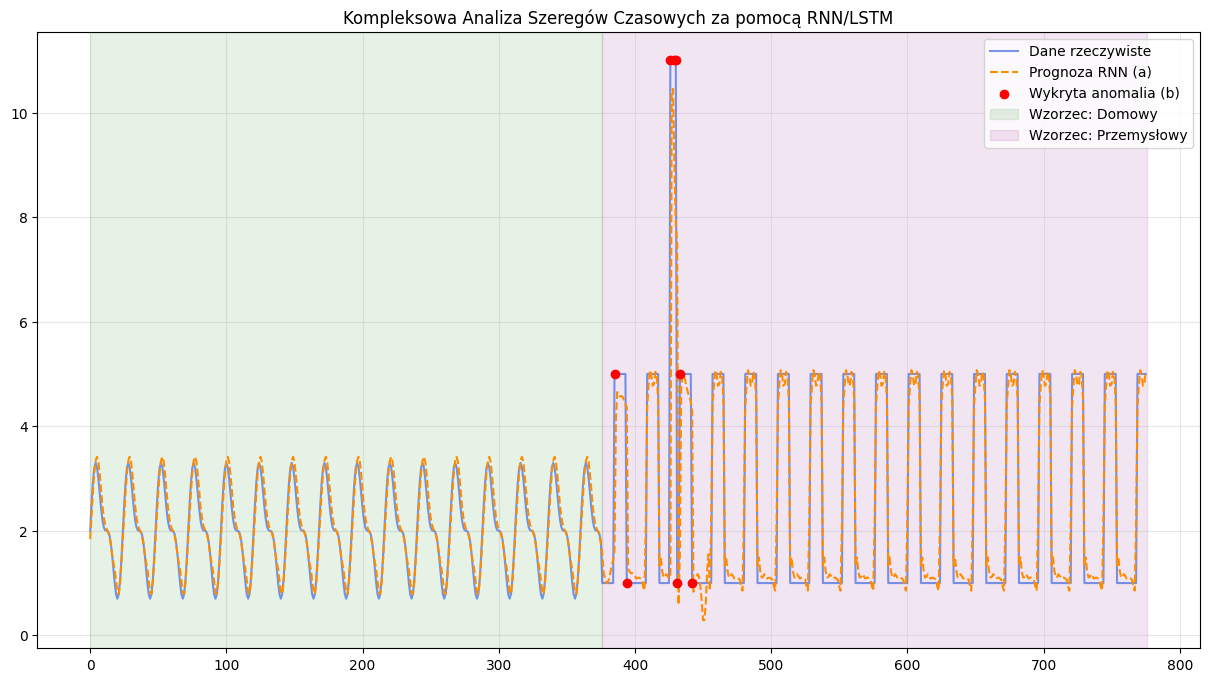

oś X: czas
oś Y: ilość m^3/h 
Liczba wykrytych anomalii: 8


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler

# Generowanie danych
np.random.seed(42)
t = np.arange(0, 400)

# Wzorzec 1: Domowy (szczyty rano i wieczorem) 
pattern_home = np.sin(2 * np.pi * t / 24) + 0.5 * np.sin(4 * np.pi * t / 24) + 2
# Wzorzec 2: Przemysłowy (stały wysoki pobór w dzień)
pattern_ind = np.where((t % 24 > 8) & (t % 24 < 18), 5, 1)

# Doddanie anomalii
data = np.concatenate([pattern_home, pattern_ind])
# Fake anomaly 
data[450:455] += 10  
data = data.reshape(-1, 1)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


# Look-back
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i : i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)


WINDOW = 24
X, y = create_sequences(data_scaled, WINDOW)

inputs = Input(shape=(WINDOW, 1))
lstm_out = LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)  # Wyjście dla prognozy
model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=50, verbose=0, batch_size=16)


# Prognozowanie
predictions_scaled = model.predict(X)
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y)

# Wykrywanie anomalii
errors = np.abs(actual - predictions)
threshold = np.mean(errors) + 3 * np.std(errors)  
anomalies = errors > threshold


def identify_pattern(seq):
    return "PRZEMYSŁOWY" if np.mean(seq) > 3 else "DOMOWY"


plt.figure(figsize=(15, 8))
plt.plot(actual, label="Dane rzeczywiste", color="royalblue", alpha=0.7)
plt.plot(predictions, label="Prognoza RNN (a)", color="darkorange", linestyle="--")

# Zaznaczanie anomalii
plt.scatter(
    np.where(anomalies)[0],
    actual[anomalies],
    color="red",
    label="Wykryta anomalia (b)",
    zorder=5,
)

# Opis wzorców  
plt.axvspan(0, 400 - WINDOW, color="green", alpha=0.1, label="Wzorzec: Domowy")
plt.axvspan(
    400 - WINDOW,
    len(actual),
    color="purple",
    alpha=0.1,
    label="Wzorzec: Przemysłowy",
)

plt.title("Kompleksowa Analiza Szeregów Czasowych za pomocą RNN/LSTM")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print("oś X: czas")
print("oś Y: ilość m^3/h ")
print(f"Liczba wykrytych anomalii: {np.sum(anomalies)}")
